# Import

In [438]:
import pandas as pd
from src.load_datasets import load_dataset, load_rankings
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from scipy.stats import chi2_contingency

In [335]:
# figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set()
sns.set_theme(style="whitegrid")
#sns.set_palette(palette="Set2")
sns.set_palette(palette="Paired")
# set seed
np.random.seed(7)

# Get data

In [336]:
data = load_dataset('../../data/raw/dataset.csv')
rankings = load_rankings('../../data/raw/rankings.csv')

Loading data ...
Loading rankings ...


# Checkout data
* Overview
* NaN values
* Unique values
* Distribution

In [337]:
data.head(6)

,encoder,dataset,model,tuning,scoring,cv_score
0,BE,3,DTC,full,ACC,0.908341
1,BE,3,DTC,full,AUC,0.906854
2,BE,3,DTC,full,F1,0.916533
3,BE,3,DTC,model,ACC,0.967145
4,BE,3,DTC,model,AUC,0.967233
5,BE,3,DTC,model,F1,0.968161


Findings: Data consists of five categorical columns:
* **encoder**: The encoder used for the training.
* **dataset**: OpenML id of the dataset on which it is trained on.
* **model**: Abbreviation of the model used for the training.
* **tuning**: Indicator if and how the model was tuned.
* **scoring**: The evaluation metric used for the model.
* **cv_score**: The cross validation score of the selected model on a dataset, using an encoder, any kind of tuning and a scoring for the training.

In [338]:
print("Sum of Nan values for each feature:", "\n", "*"*20, "\n", data.isnull().sum())

Sum of Nan values for each feature: 
 ******************** 
 encoder     0
dataset     0
model       0
tuning      0
scoring     0
cv_score    0
dtype: int64


Findings: There are no NaN values regarding the train features.

In [339]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48046 entries, 0 to 48045
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   encoder   48046 non-null  object 
 1   dataset   48046 non-null  int64  
 2   model     48046 non-null  object 
 3   tuning    48046 non-null  object 
 4   scoring   48046 non-null  object 
 5   cv_score  48046 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 2.6+ MB


Findings:
* Dataset ID is given as integer, but in fact categorical.
* Else is already known and described previously.

In [340]:
data.describe(include='object')

,encoder,model,tuning,scoring
count,48046,48046,48046,48046
unique,32,5,3,3
top,OE,LR,no,ACC
freq,1544,12240,22857,16018


In [341]:
print(f"Encoders ({len(data['encoder'].unique())}): ", "\n", data["encoder"].unique(), "\n", "*"*20)
print(f"Datasets Id ({len(data['dataset'].unique())}): ", "\n", data["dataset"].unique(), "\n", "*"*20)
print(f"Models ({len(data['model'].unique())}): ", "\n", data["model"].unique(), "\n", "*"*20)
print(f"Tuning Info ({len(data['tuning'].unique())}): ", "\n", data["tuning"].unique(), "\n", "*"*20)
print(f"Scoring: ({len(data['scoring'].unique())})", "\n", data["scoring"].unique(), "\n", "*"*20)

Encoders (32):  
 ['BE' 'BUCV10RGLMME' 'BUCV10TE' 'BUCV2RGLMME' 'BUCV2TE' 'BUCV5RGLMME'
 'BUCV5TE' 'CBE' 'CE' 'CV10RGLMME' 'CV10TE' 'CV2RGLMME' 'CV2TE'
 'CV5RGLMME' 'CV5TE' 'DE' 'DTEM10' 'DTEM2' 'DTEM5' 'ME01E' 'ME10E' 'ME1E'
 'MHE' 'OE' 'OHE' 'PBTE0001' 'PBTE001' 'PBTE01' 'RGLMME' 'SE' 'TE' 'WOEE'] 
 ********************
Datasets Id (50):  
 [    3    29    31    38    50    51    56   333   334   451   470   881
   956   959   981  1037  1111  1112  1114  1169  1235  1461  1463  1486
  1506  1511  1590  6332 23381 40536 40945 40981 40999 41005 41007 41162
 41224 42178 42343 42344 42738 42750 43098 43607 43890 43892 43896 43897
 43900 43922] 
 ********************
Models (5):  
 ['DTC' 'KNC' 'LGBMC' 'LR' 'SVC'] 
 ********************
Tuning Info (3):  
 ['full' 'model' 'no'] 
 ********************
Scoring: (3) 
 ['ACC' 'AUC' 'F1'] 
 ********************


## Feature Distribution

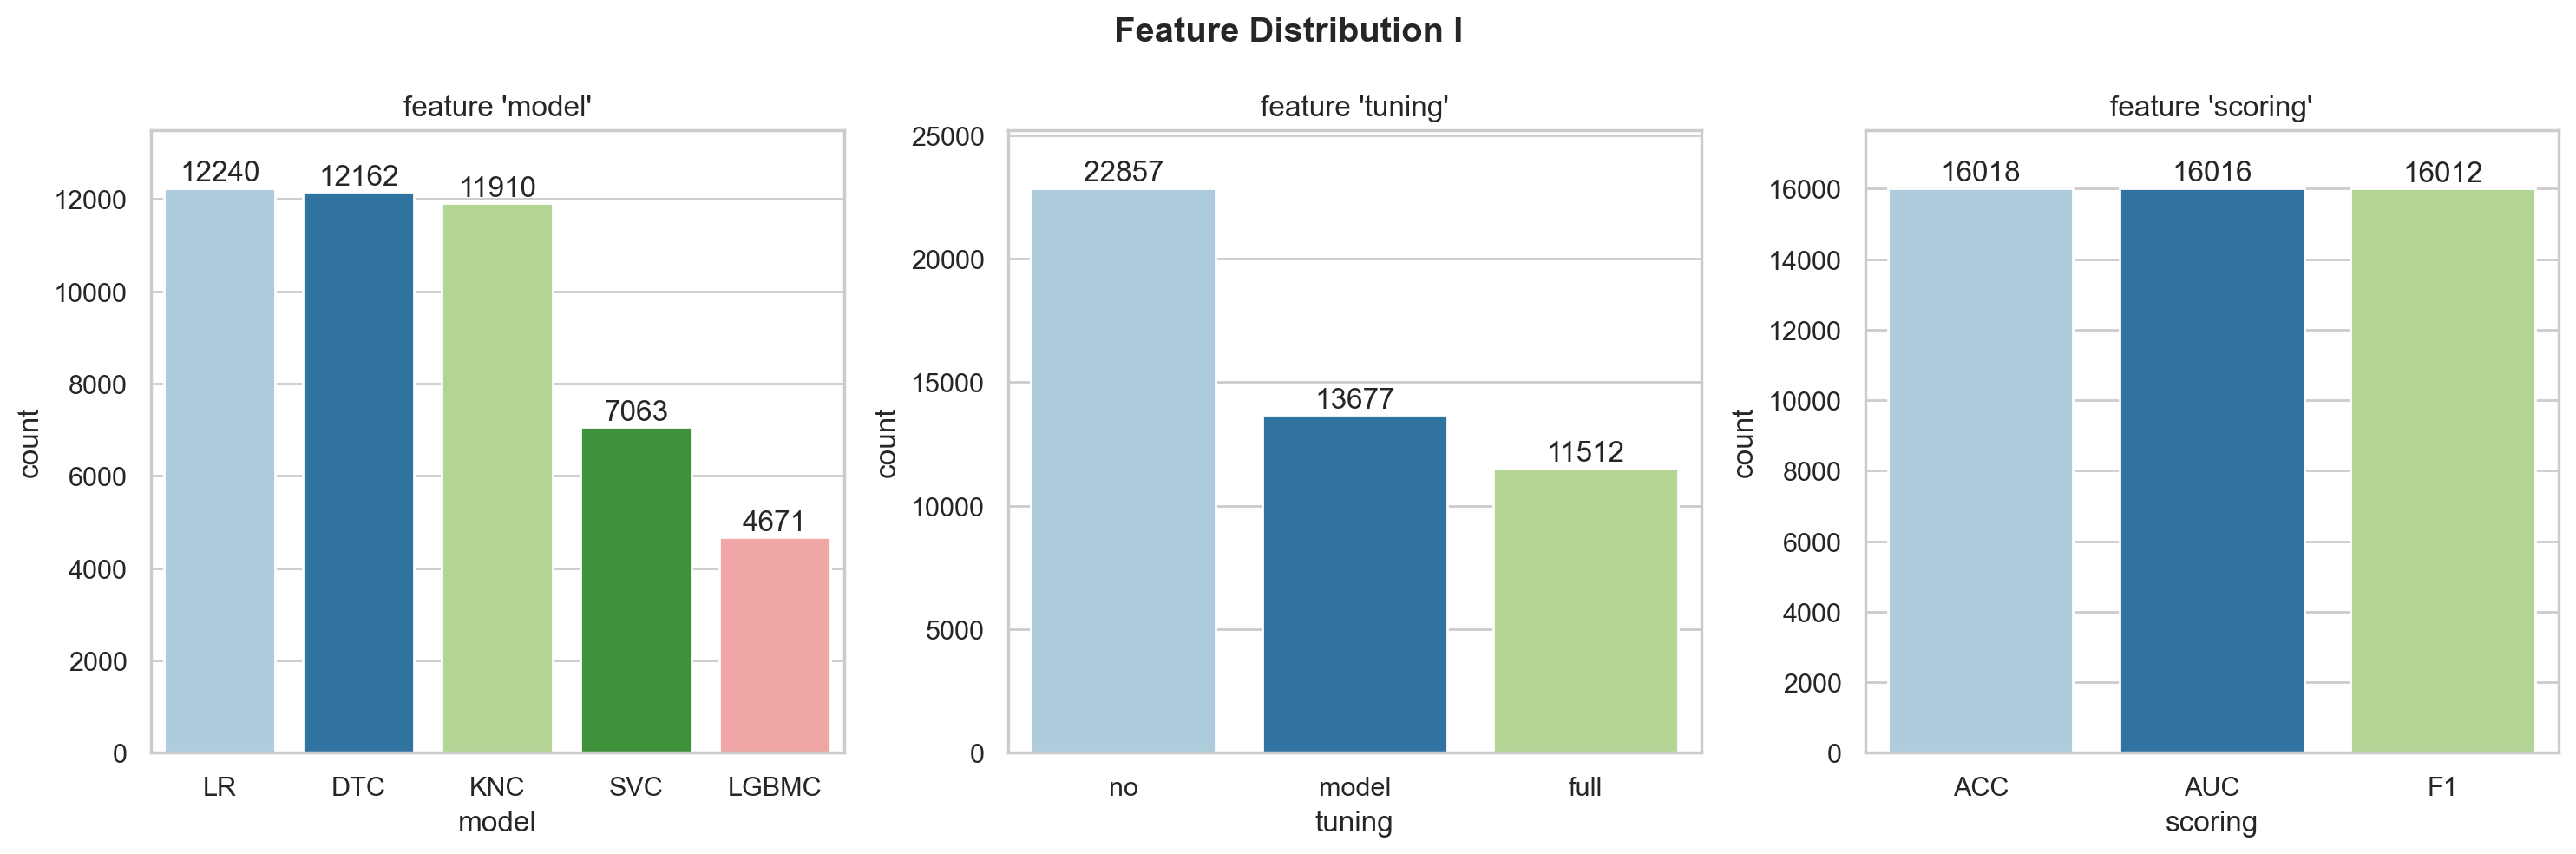

CPU times: total: 172 ms
Wall time: 444 ms


In [420]:
%%time
df = data[["model", "tuning", "scoring"]]
# Define the number of columns and rows for the subplot grid
ncols = 3
nrows = (df.shape[1] // ncols) + (1 if df.shape[1] % ncols != 0 else 0)

# Create a figure and subplots with the specified dimensions
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5))
fig.suptitle('Feature Distribution I', fontweight='bold')

# Loop over each column in the dataframe and plot its distribution
for i, (col, ax) in enumerate(zip(df.columns, axes.flatten())):
    sns.countplot(x=col, data=df, ax=ax, order=df[col].value_counts().index)
    ax.set_title("feature "+ "'" + col + "'")
    ax.set_ylabel("count")
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], ylim[1] * 1.05)

    # Add numbers in the top of the bars
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 6), textcoords = 'offset points')


plt.tight_layout()
plt.show()

Findings:
*  Model: 'DTC', 'KNC' and 'LR' are the most used models and equally distributed with only a small difference whereas there is a bigger gap to the other models being SVC with 7063 and LGBMC with 4671.
* Tuning: Most of the models are not tuned with > 22 000. A fully tuned model was done the least in the dataset with 11 512. However there is no big gap and this more tiny imbalance can be ignored.

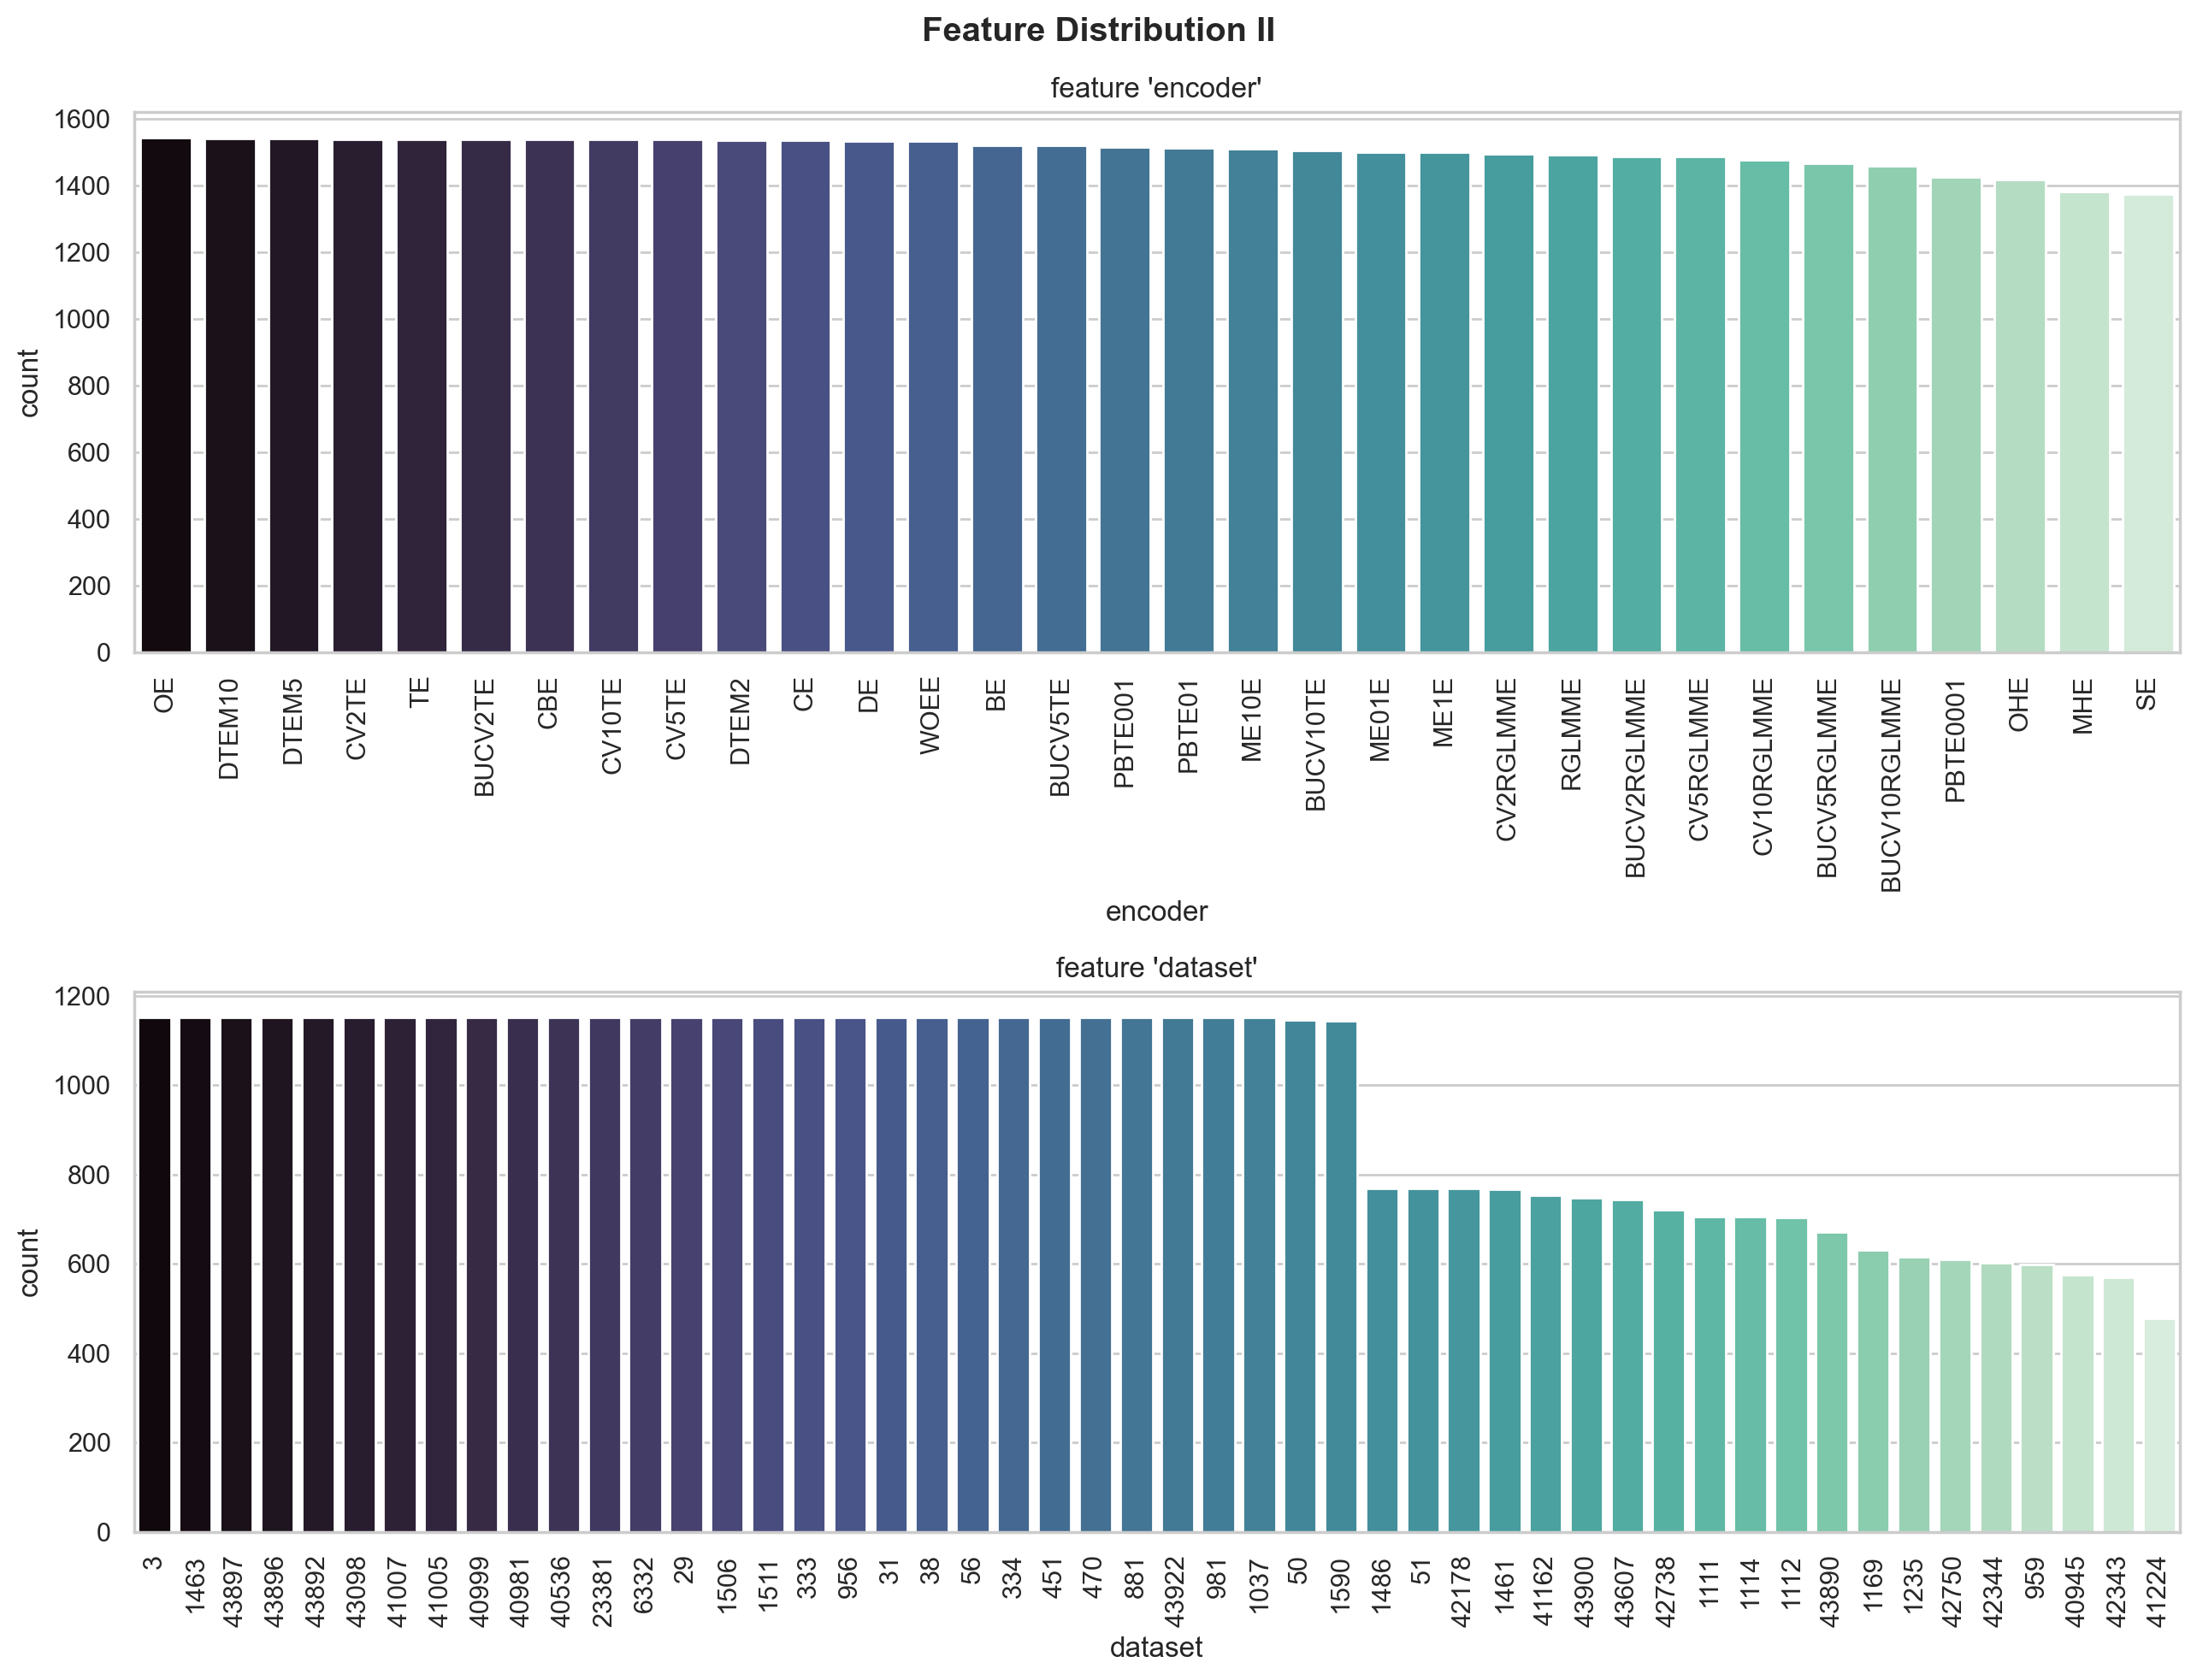

CPU times: total: 391 ms
Wall time: 886 ms


In [436]:
%%time
df = data[["encoder", "dataset"]]
# Define the number of columns and rows for the subplot grid
ncols = 1
nrows = (df.shape[1] // ncols) + (1 if df.shape[1] % ncols != 0 else 0)

# Create a figure and subplots with the specified dimensions
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(13, 10))
fig.suptitle('Feature Distribution II', fontweight='bold')

# Loop over each column in the dataframe and plot its distribution
for i, (col, ax) in enumerate(zip(df.columns, axes.flatten())):
    sns.countplot(x=col, data=df, ax=ax, order=df[col].value_counts().index, palette="mako")
    ax.set_title("feature "+ "'" + col + "'")
    ax.set_ylabel("count")
    # Rotate x-labels
    plt.setp(ax.get_xticklabels(), rotation=90)

plt.tight_layout()
plt.show()

Findings:
* Encoders are more or less equally distributed
* Datasets are not equally distributed (some datasets are used more often than others, as can be seen in the plot). Since we do not have any external information about the datasets we cannot say if this is a problem or not and what the reason for this is.

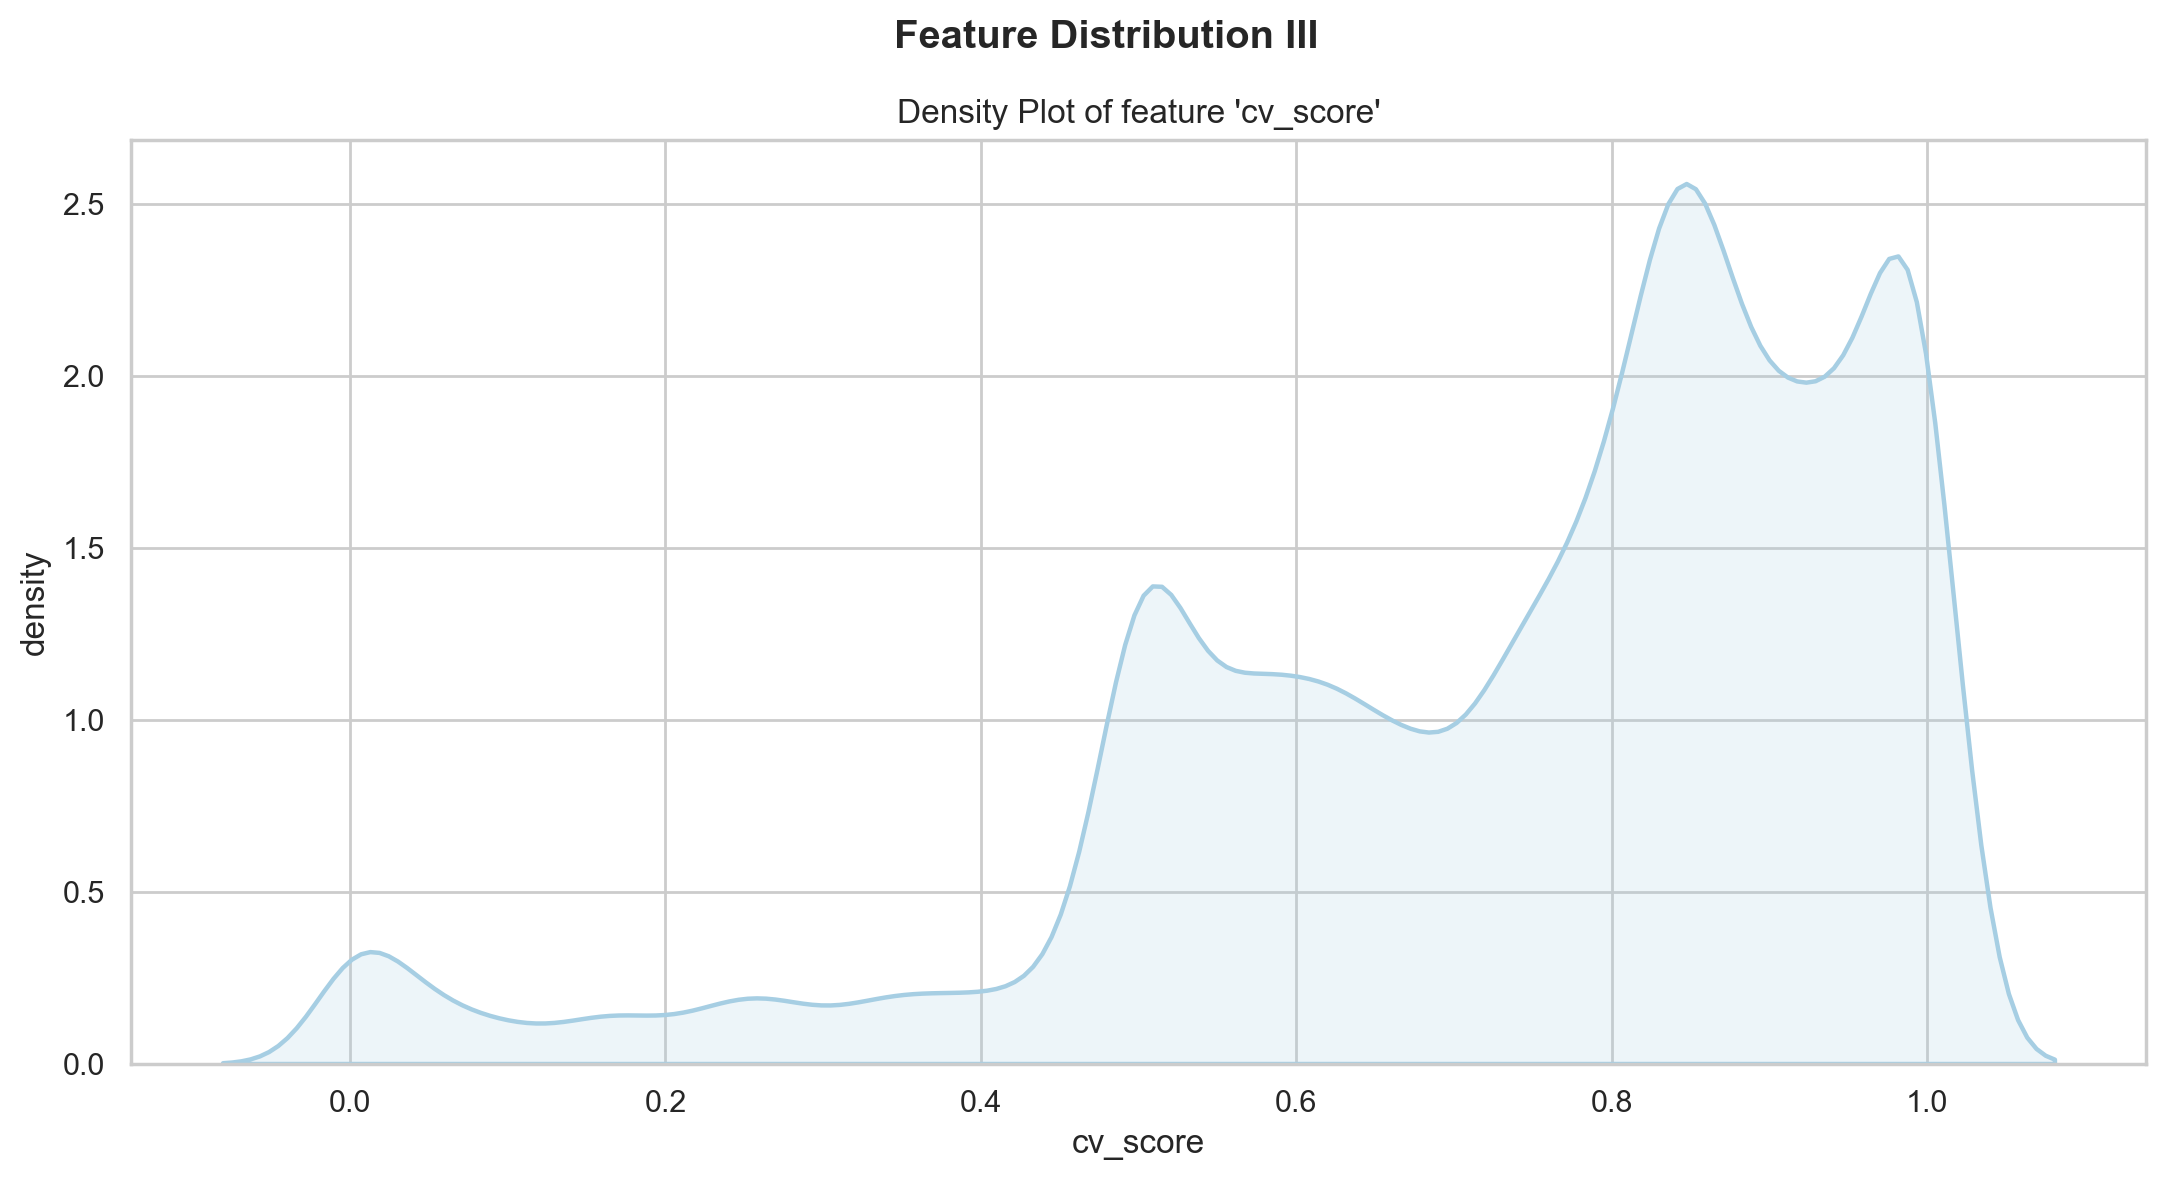

CPU times: total: 62.5 ms
Wall time: 356 ms


In [390]:
%%time
df = data[["cv_score"]]
# Create kde plot figure
fig, ax = plt.subplots(figsize=(13, 6))
fig.suptitle('Feature Distribution III', fontweight='bold')
# Plot kde plot
sns.kdeplot(data=df, x="cv_score", ax=ax, fill=True, alpha=.2, linewidth=1.6)
ax.set_ylabel("density")
ax.set_title("Density Plot of feature "+ "'" + "cv_score" + "'")

# Show plot
plt.show()

Findings:
* No unusual distribution or any Outlier or Imbalance in the Scoring

## Feature Correlation

In [492]:
# Import Correlation Fnction from previous pipeline
def plot_cramers_v_corr_heatmap(data=None, features_x_axis=None, features_y_axis=None, annotate_map=True):
    """
    Calculates the cramers V correlation of all features and plots them in a heatmap.
    Cramers V is based on Chi square, for reference see: https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V
    Note that this function is desined to work for categorical features only!
    Code was copied and modified from this source: https://www.kaggle.com/code/chrisbss1/cramer-s-v-correlation-matrix/notebook

    :param data: Dataframe with features and values
    :param features_x_axis: The features to plot on the x axis
    :param features_y_axis: The features to plot on the y axis
    """
    # Encode features
    label = preprocessing.LabelEncoder()
    data_encoded = pd.DataFrame()

    for i in data.columns :
        data_encoded[i]=label.fit_transform(data[i])

    # Internal function to calculate cramers V for two features
    def _cramers_V(var1, var2) :
        crosstab = np.array(pd.crosstab(var1,var2, rownames=None, colnames=None))  # Cross table building
        stat = chi2_contingency(crosstab)[0]  # Keeping of the test statistic of the Chi2 test
        obs = np.sum(crosstab)  # Number of observations
        mini = min(crosstab.shape) - 1  # Take the minimum value between the columns and the rows of the cross table
        return (stat / (obs * mini))
        #return stat

    # Calculate values for each pair of features
    rows= []
    for var1 in data_encoded:
        col = []
        for var2 in data_encoded :
            cramers = _cramers_V(data_encoded[var1], data_encoded[var2])  # Cramer's V test
            col.append(round(cramers, 4))  # Keeping of the rounded value of the Cramer's V
        rows.append(col)

    # Create a pandas df from the results
    cramers_results = np.array(rows)
    cramers_v_corr_matrix = pd.DataFrame(cramers_results, columns = data_encoded.columns, index =data_encoded.columns)

    # Set features for axis
    if features_x_axis is None:
        features_x_axis = list(data.columns)
    if features_y_axis is None:
        features_y_axis = list(data.columns)

    # Plot correlations
    plt.figure(figsize=(7,6))
    sns.heatmap(cramers_v_corr_matrix[features_x_axis].loc[features_y_axis], annot=annotate_map, cmap=sns.cm.mako_r)
    plt.title("Cramers V Correlation between Features", fontweight="bold")
    plt.tight_layout()
    plt.show()


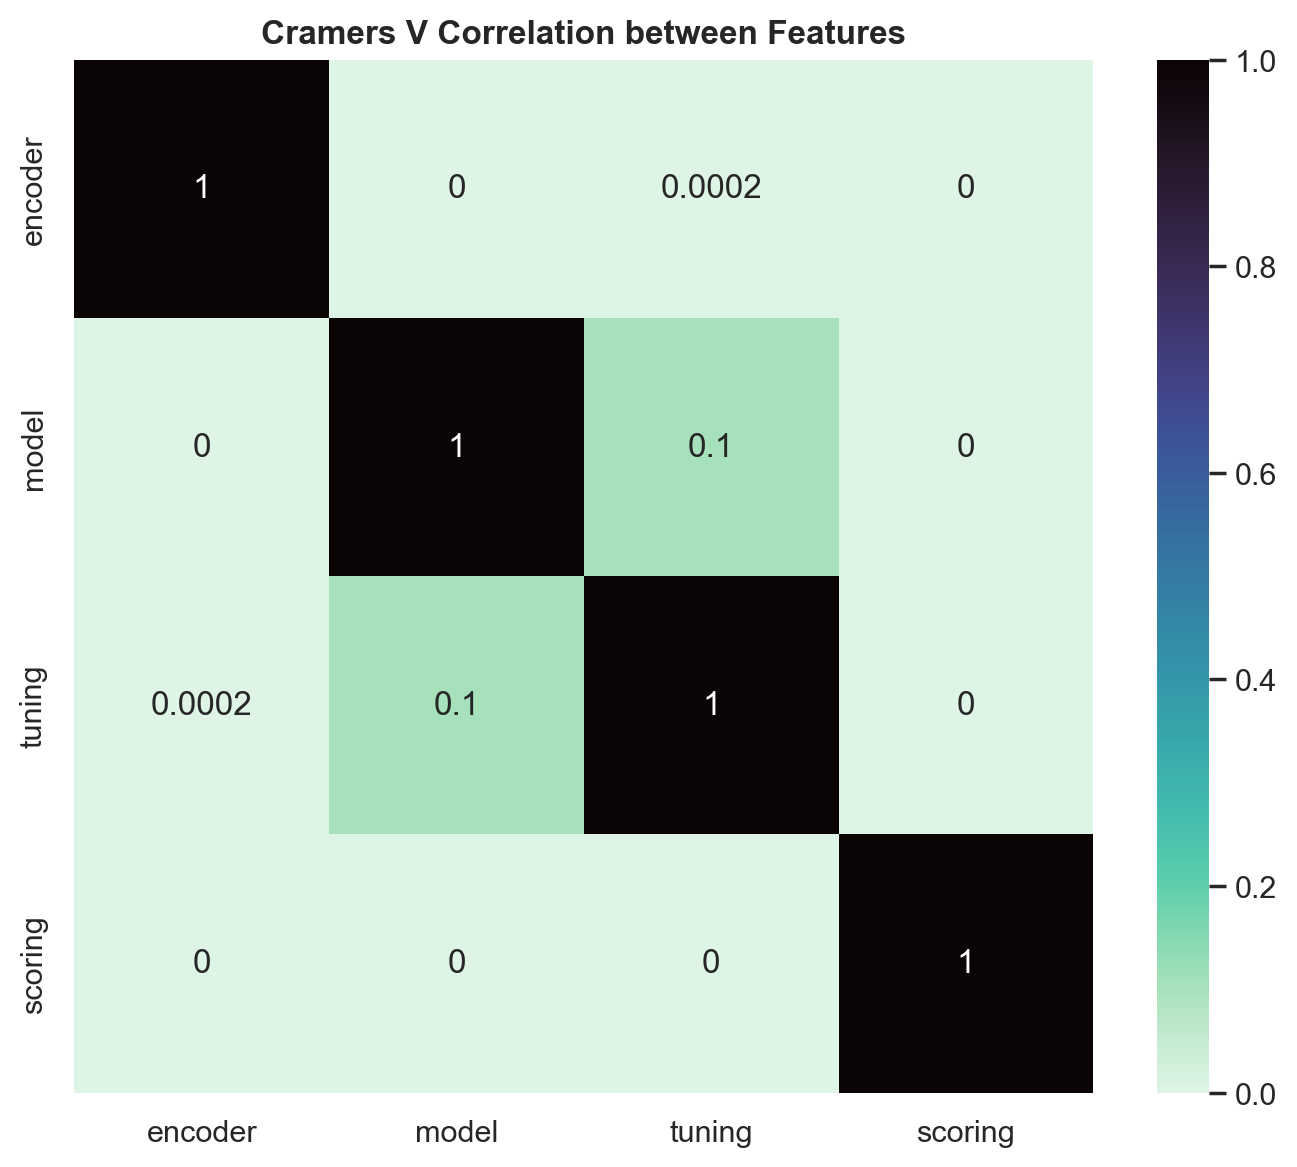

In [493]:
cat_feature_list = data.columns[data.dtypes == "object"].tolist()
plot_cramers_v_corr_heatmap(data=data[cat_feature_list], features_x_axis=cat_feature_list, features_y_axis=cat_feature_list)

Findings: No significant correlation worth mentioning between features.

# Checkout rankings
* NaN values
* Best and Worst Encoder (via mean of all rankings, min of all rankings, max of all rankings)
* Best and Worst Encoder for different feature combinations

In [345]:
rankings

3                                       ... 43922              \
              DTC                                  KNC  ...    LR               
             full        model          no        full  ... model  no           
              ACC AUC F1   ACC AUC  F1 ACC AUC F1  ACC  ...    F1 ACC AUC  F1   
encoder                                                 ...                     
BE              1   1  1    12  12  12   1   1  1   21  ...     7   8   8   6   
BUCV10RGLMME    1   1  1    14  14  13   1   1  1   16  ...    12  10  10  10   
BUCV10TE        1   1  1     0   0   0   1   1  1    9  ...    11   9   9   9   
BUCV2RGLMME     1   1  1    18  18  18   1   1  1   15  ...    18  14  14  14   
BUCV2TE         1   1  1     6   6   6   1   1  1    8  ...    15  13  13  13   
BUCV5RGLMME     1   1  1    16  17  16   1   1  1   14  ...    14  12  12  11   
BUCV5TE         1   1  1     4   4   4   1   1  1    7  ...    13  11  11  12   
CBE             3   3  4    25  24  25   4   3  4   27  ...     4   5   5   5   
CE              1   1  1     8   8   8   1   1  1   26  ...     5   2   2   4   
CV10RGLMME      1   1  1    15  16  15   1   1  1   18  ...    21  22  23  24   
CV10TE          1   1  1    13  13  14   1   1  1   12  ...    17  21  21  21   
CV2RGLMME       1   1  1    21  21  21   1   1  1   11  ...    23  24  24  23   
CV2TE           1   1  1    22  22  22   1   1  1    2  ...    27  20  20  20   
CV5RGLMME       0   0  0    20  20  20   0   0  0   19  ...    20  19  19  19   
CV5TE           0   0  0    10  10  10   0   0  0    5  ...    26  18  18  18   
DE              4   4  3    24  25  24   3   4  3   28  ...    31  30  30  30   
DTEM10          1   1  1     3   3   3   1   1  1   13  ...     9  16  16  16   
DTEM2           1   1  1    17  15  17   1   1  1    1  ...     3   6   6   7   
DTEM5           1   1  1     3   3   3   1   1  1   10  ...    10  15  15  15   
ME01E           1   1  1     3   3   3   1   1  1    6  ...    19  23  22  22   
ME10E           1   1  1     3   3   3   1   1  1    4  ...    28  27  27  27   
ME1E            1   1  1     3   3   3   1   1  1    6  ...    25  26  26  26   
MHE             1   1  1     2   2   2   1   1  1   24  ...     1   1   1   2   
OE              1   1  1     9   9   9   1   1  1   23  ...     8   7   7   8   
OHE             1   1  1     5   5   5   1   1  1   22  ...     2   4   4   3   
PBTE0001        1   1  1     7   7   7   1   1  1    9  ...    22  17  17  17   
PBTE001         1   1  1    11  11  11   1   1  1    3  ...    29  28  28  28   
PBTE01          2   2  2    23  23  23   2   2  2   20  ...    30  29  29  29   
RGLMME          1   1  1    19  19  19   1   1  1   17  ...    24  25  25  25   
SE              1   1  1     1   1   1   1   1  1   25  ...     6   3   3   1   
TE              1   1  1     3   3   3   1   1  1    9  ...    16  23  22  22   
WOEE            1   1  1     3   3   3   1   1  1    0  ...     0   0   0   0   

                                       
              SVC                      
             full          no          
              ACC AUC  F1 ACC AUC  F1  
encoder                                
BE              0   0   4   4   4   4  
BUCV10RGLMME   14  14  10  21  21  21  
BUCV10TE       14  14  10  12  12  12  
BUCV2RGLMME    19  19  19   7   7   8  
BUCV2TE        21  21  21   8   8   7  
BUCV5RGLMME    13  13   9  14  15  15  
BUCV5TE        13  13   9   9   9   9  
CBE             2   2   0   1   1   0  
CE             25  24  24   0   0   2  
CV10RGLMME     20  20  20  23  23  23  
CV10TE         22  22  22  16  16  16  
CV2RGLMME      17  17  17  22  22  22  
CV2TE          22  22  22  16  16  16  
CV5RGLMME      23  23  23  13  13  13  
CV5TE          15  15  15  13  13  13  
DE             24  25  25  26  26  26  
DTEM10          6   5   3  19  19  19  
DTEM2           4   3   1  15  14  14  
DTEM5           5   4   2  19  19  19  
ME01E          15  15  15  18  18  18  
ME10E          10 

## Nan Values

Findings: Rankings consits of a multiindex, where the first level is the dataset and the second, third and fourth level are the feature combinations. The values are the rankings of the encoders for the feature combination on the dataset. The lower the value, the better the encoder. The index represents the encoder.

In [346]:
# check null values across columns which are here the features
nan_values = pd.DataFrame({"nan_values_count": rankings.isna().sum()})
nan_values.index.rename(rankings.columns.name, inplace=True)
nan_values = nan_values[nan_values.nan_values_count > 0].sort_values(ascending=False, by="nan_values_count")
nan_values_total = nan_values["nan_values_count"].sum()

# Check if any missing
print("Any NaN values?", f"{rankings.isna().values.any()}, there are {nan_values_total}!")
# Check how many missing values
print(f"Sum of Nan values for each feature combination ({nan_values.shape[0]}):")
nan_values

Any NaN values? True, there are 1490!
Sum of Nan values for each feature combination (331):


nan_values_count
dataset model tuning scoring                  
42344   SVC   no     AUC                    31
42343   SVC   no     F1                     31
42344   SVC   no     F1                     31
                     ACC                    31
42343   SVC   no     ACC                    31
...                                        ...
1169    LR    model  ACC                     1
                     AUC                     1
                     F1                      1
1235    LR    no     ACC                     1
50      DTC   model  ACC                     1

[331 rows x 1 columns]

In [347]:
# Check for any relationship between the missing values and the features
print(f"Dataset: {len(nan_values.index.get_level_values(0).unique().tolist())} out of {len(rankings.columns.get_level_values(0).unique().tolist())} datasets are part of a feature combination with missing values.")
print(f"Model: {len(nan_values.index.get_level_values(1).unique().tolist())} out of {len(rankings.columns.get_level_values(1).unique().tolist())} models are part of a feature combination with missing values.")
print(f"Tuning: {len(nan_values.index.get_level_values(2).unique().tolist())} out of {len(rankings.columns.get_level_values(2).unique().tolist())} tunings are part of a feature combination with missing values.")
print(f"Scoring: {len(nan_values.index.get_level_values(3).unique().tolist())} out of {len(rankings.columns.get_level_values(3).unique().tolist())} scorings are part of a feature combination with missing values.")

Dataset: 19 out of 50 datasets are part of a feature combination with missing values.
Model: 5 out of 5 models are part of a feature combination with missing values.
Tuning: 3 out of 3 tunings are part of a feature combination with missing values.
Scoring: 3 out of 3 scorings are part of a feature combination with missing values.


In [348]:
# Check dataset with most missing values
print("Sum of Nan values for each dataset:")
dataset_nan_count = pd.DataFrame(nan_values.groupby(level=0).sum().sort_values(ascending=False, by="nan_values_count"))
dataset_count = pd.DataFrame(rankings.stack().stack().stack().stack().reset_index().groupby(["level_4"])["level_4"].count().sort_values(ascending=False))
dataset_count.index.rename("dataset", inplace=True)
dataset_count.rename({"level_4": "count"}, axis=1, inplace=True)
dataset_nan_count = dataset_nan_count.join(dataset_count)
dataset_nan_count["relative_nan_values_count"] = dataset_nan_count["nan_values_count"] / dataset_nan_count["count"] * 100
dataset_nan_count.drop("count", axis=1, inplace=True)
dataset_nan_count

Sum of Nan values for each dataset:


,nan_values_count,relative_nan_values_count
dataset,,
42343,198,34.736842
40945,192,33.333333
959,169,28.213689
42344,166,27.574751
42750,159,26.108374
41224,98,20.502092
43890,97,14.456036
1112,64,9.090909
1114,63,8.936170


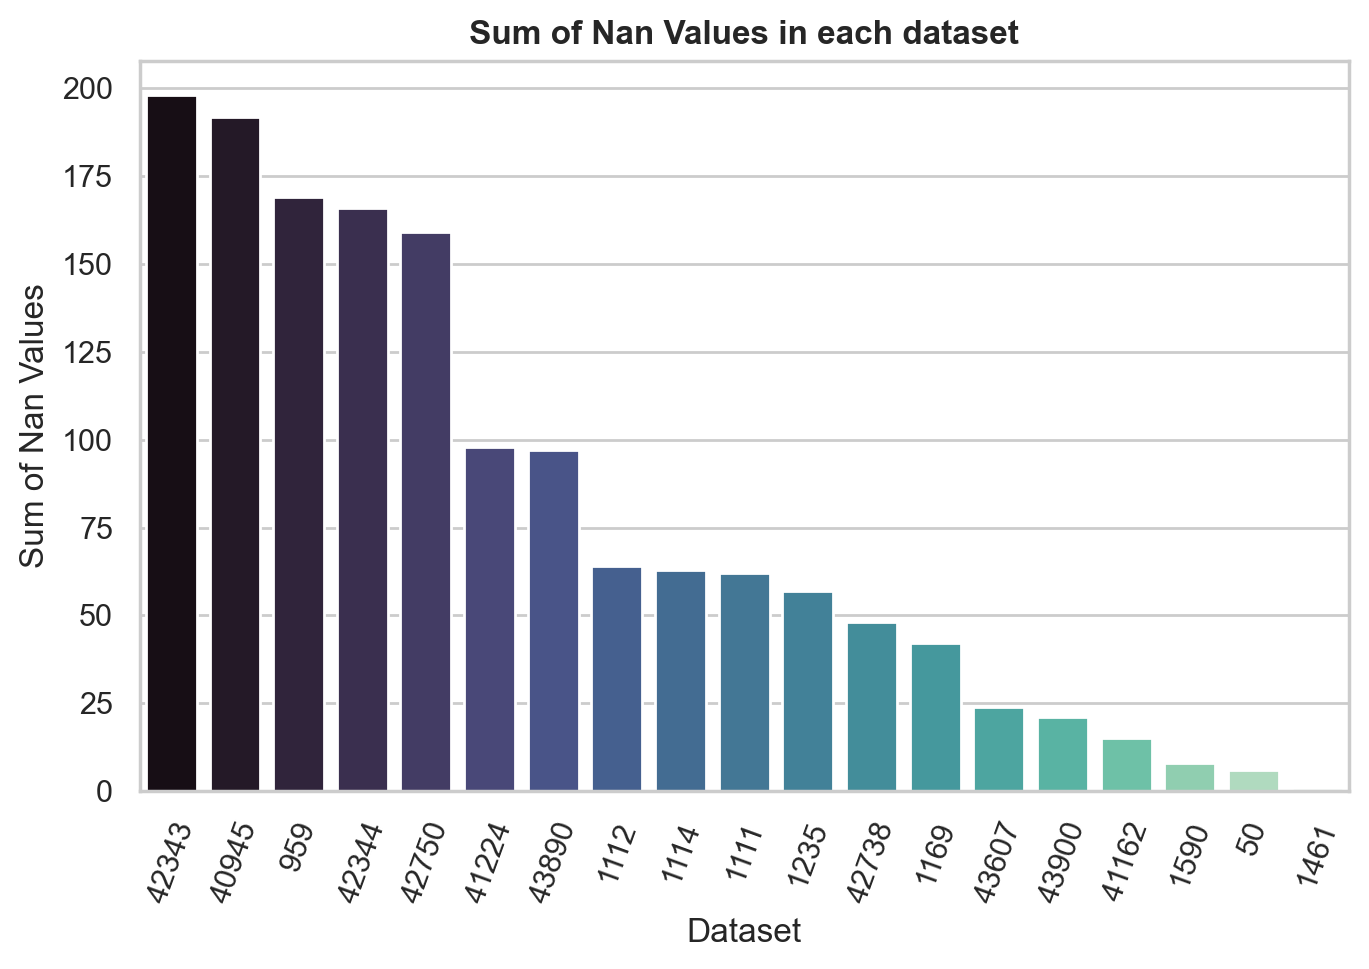

In [511]:
# plot sum of nan values for each dataset
fig, ax = plt.subplots(figsize=(7, 5))
sns.barplot(x=dataset_nan_count.index, y="nan_values_count", data=dataset_nan_count, ax=ax, palette="mako")
ax.set_title("Sum of Nan Values in each dataset", fontweight="bold")
ax.set_xlabel("Dataset")
ax.set_ylabel("Sum of Nan Values")
plt.xticks(rotation=70)
plt.tight_layout()
plt.show()

In [496]:
# check nan values across index which are here the encoders
print("Sum of Nan values for each encoder:")
encoder_nan_counts = pd.DataFrame(rankings.isna().sum(axis=1).sort_values(ascending=False).rename("nan_values_count"))
encoder_nan_counts["relative_nan_values_count"] = encoder_nan_counts / rankings.shape[1] * 100
display(encoder_nan_counts)

print(f"{encoder_nan_counts[encoder_nan_counts.relative_nan_values_count > 0].shape[0]} out of {encoder_nan_counts.shape[0]} encoders have missing values.")

Sum of Nan values for each encoder:


,nan_values_count,relative_nan_values_count
encoder,,
SE,175,11.304910
MHE,165,10.658915
OHE,130,8.397933
PBTE0001,123,7.945736
BUCV10RGLMME,88,5.684755
BUCV5RGLMME,82,5.297158
CV10RGLMME,71,4.586563
CV5RGLMME,62,4.005168
BUCV2RGLMME,60,3.875969


32 out of 32 encoders have missing values.


Findings:
* There are 331 feature combinations with missing values, which sum up to 1490.
* Feature Relationship:
    * Model, Tuning; Scoring: The missing values are not related to the model, tuning or scoring.
    * Dataset: However, 19 out of 50 datasets are part of a feature combination with missing values. Dataset with ID 42343, and ID 40945 is most affected. Yet these datasets are also part of feature combinations without missing values. Thus, the missing values are not related to the dataset. Looking at the relative numbers there is no dataset with more than 35% missing values of its occurence.
    * Encoder: SE encoder has the most missing values. However, the missing values are not related to the encoders as it seems, there is no pattern to be seen. Looking at the relative numbers there is no encoder with more than 12% missing values of its occurence.

## Best and Worst Encoder

In [551]:
# get min, mean, median and max of all rankings of each encoder
encoder_rankings = rankings.aggregate(["min", "mean", "median", "max"], axis=1).sort_values(ascending=False, by="mean")
encoder_rankings["mean"] = encoder_rankings["mean"].round(4)
encoder_rankings

,min,mean,median,max
encoder,,,,
DE,0.0,14.0894,14.0,31.0
CE,0.0,12.1569,10.0,31.0
OE,0.0,11.8834,9.0,31.0
CBE,0.0,11.5523,10.0,31.0
MHE,0.0,11.2719,9.0,31.0
ME01E,0.0,11.0826,11.0,31.0
ME1E,0.0,10.6987,10.0,30.0
CV10RGLMME,0.0,10.6872,10.0,30.0
PBTE01,0.0,10.6753,9.0,30.0


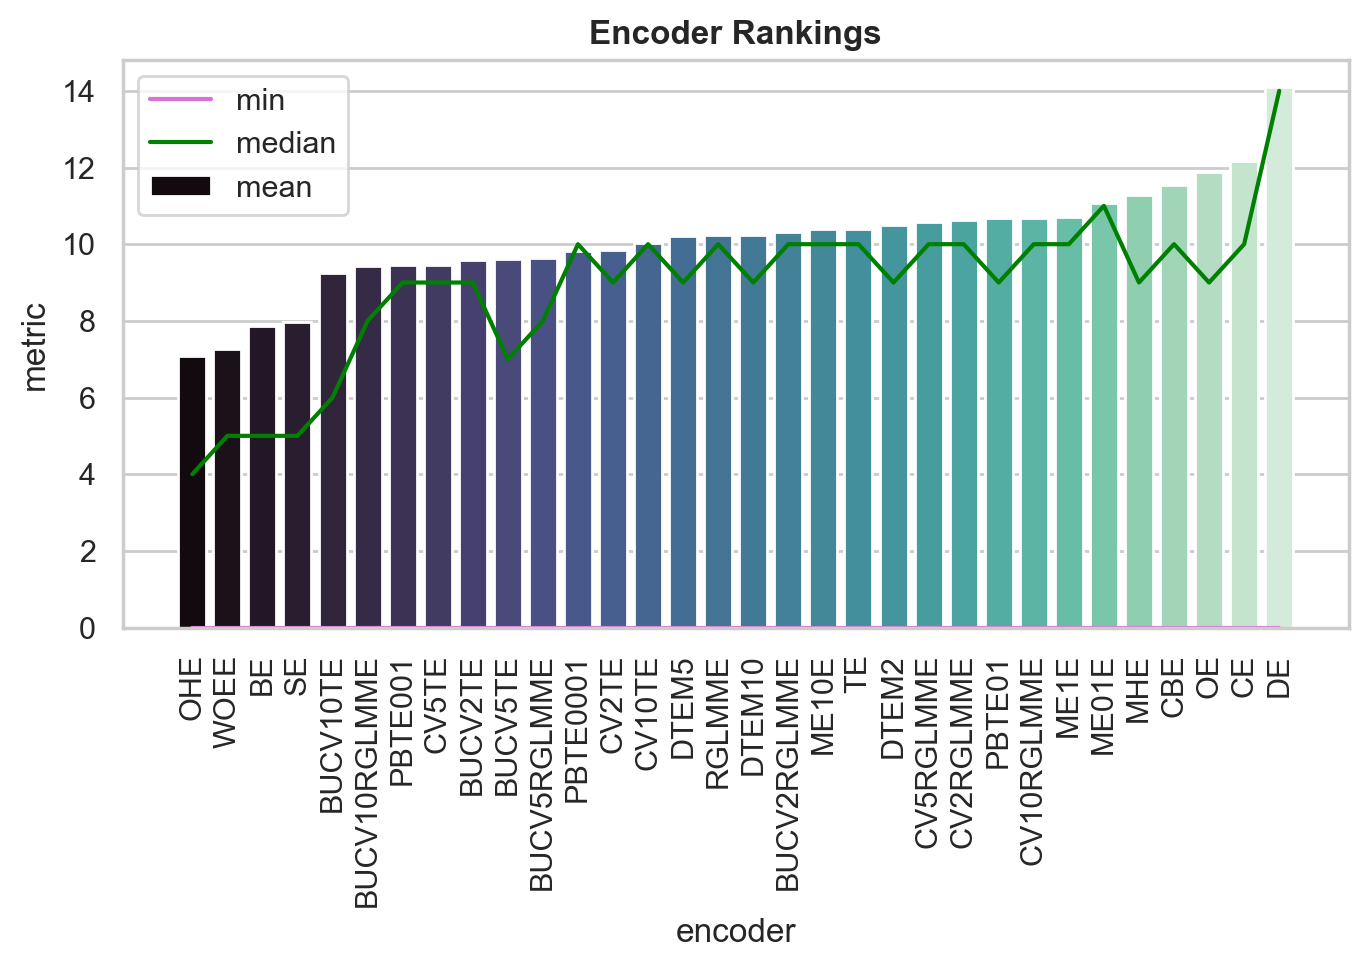

In [547]:
# plot min, mean, median and max of all rankings of each encoder
fig, ax = plt.subplots(figsize=(7, 5))
sns.barplot(x=encoder_rankings.index, y="mean", data=encoder_rankings, ax=ax, palette="mako", label="mean")
sns.lineplot(x=encoder_rankings.index, y="min", data=encoder_rankings, ax=ax, label="min", color="orchid")
sns.lineplot(x=encoder_rankings.index, y="median", data=encoder_rankings, ax=ax, label="median", color="green")
ax.set_title("Encoder Rankings", fontweight="bold")
ax.set_xlabel("encoder")
ax.set_ylabel("metric")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Findings:
* Best:
    * 1st OHE - One Hot Encoding (mean 7.0797)
    * 2nd WOEE - Weight of Evidence Encoding (mean 7.2759)
    * 3d BE - Binary Encoding (mean 7.8692)
* Worst:
    * DE - Dummy Encoding (mean 14.0894)

## Rankings per Encoder and per Feature

### Dataset

In [595]:
# get mean of all rankings of each encoder and each dataset
encoder_dataset_rankings = rankings.groupby(level=0, axis='columns').mean()
sorted_columns = sorted(encoder_dataset_rankings.columns.tolist(), key=int)
encoder_dataset_rankings = encoder_dataset_rankings[sorted_columns]
encoder_dataset_rankings

,3,29,31,38,50,51,56,333,334,451,...,42738,42750,43098,43607,43890,43892,43896,43897,43900,43922
encoder,,,,,,,,,,,,,,,,,,,,,
BE,13.000000,11.083333,7.555556,4.861111,2.444444,4.375000,3.333333,9.972222,5.805556,3.472222,...,7.416667,5.714286,10.555556,5.666667,6.541667,13.666667,6.027778,2.861111,9.208333,4.472222
BUCV10RGLMME,13.777778,4.444444,7.777778,6.555556,8.888889,6.041667,6.222222,5.833333,9.861111,0.000000,...,18.291667,11.000000,10.194444,16.125000,4.666667,11.277778,4.694444,0.611111,17.708333,13.305556
BUCV10TE,11.138889,5.111111,5.000000,4.805556,6.027778,5.333333,5.138889,3.972222,2.861111,0.000000,...,20.833333,15.400000,10.805556,17.833333,5.458333,11.361111,4.805556,1.305556,18.208333,11.750000
BUCV2RGLMME,12.861111,9.416667,10.916667,6.944444,13.444444,12.375000,5.611111,4.138889,12.666667,1.027778,...,19.708333,13.428571,6.027778,12.958333,3.750000,8.250000,8.916667,0.694444,16.166667,13.305556
BUCV2TE,6.583333,9.722222,8.416667,7.916667,9.055556,8.666667,5.638889,2.083333,3.305556,1.027778,...,22.625000,13.000000,8.972222,14.625000,4.166667,8.805556,9.416667,0.777778,16.625000,12.527778
BUCV5RGLMME,12.694444,6.305556,7.222222,5.916667,10.611111,8.041667,5.527778,7.527778,9.138889,0.000000,...,18.916667,11.000000,11.277778,15.500000,4.125000,10.166667,7.027778,0.611111,16.958333,13.583333
BUCV5TE,9.666667,6.388889,7.111111,6.555556,5.888889,5.916667,5.361111,4.361111,2.944444,0.000000,...,21.333333,9.666667,10.111111,17.666667,4.750000,10.472222,8.000000,1.000000,18.875000,12.444444
CBE,22.111111,12.916667,20.666667,12.583333,24.638889,20.250000,8.500000,12.027778,12.333333,0.222222,...,23.875000,10.761905,13.138889,11.250000,3.291667,2.500000,12.750000,0.500000,9.000000,13.138889
CE,18.027778,10.888889,23.222222,13.444444,21.305556,11.791667,5.888889,8.527778,12.638889,6.250000,...,6.916667,13.047619,12.861111,10.083333,8.041667,16.166667,11.805556,5.083333,9.333333,8.500000


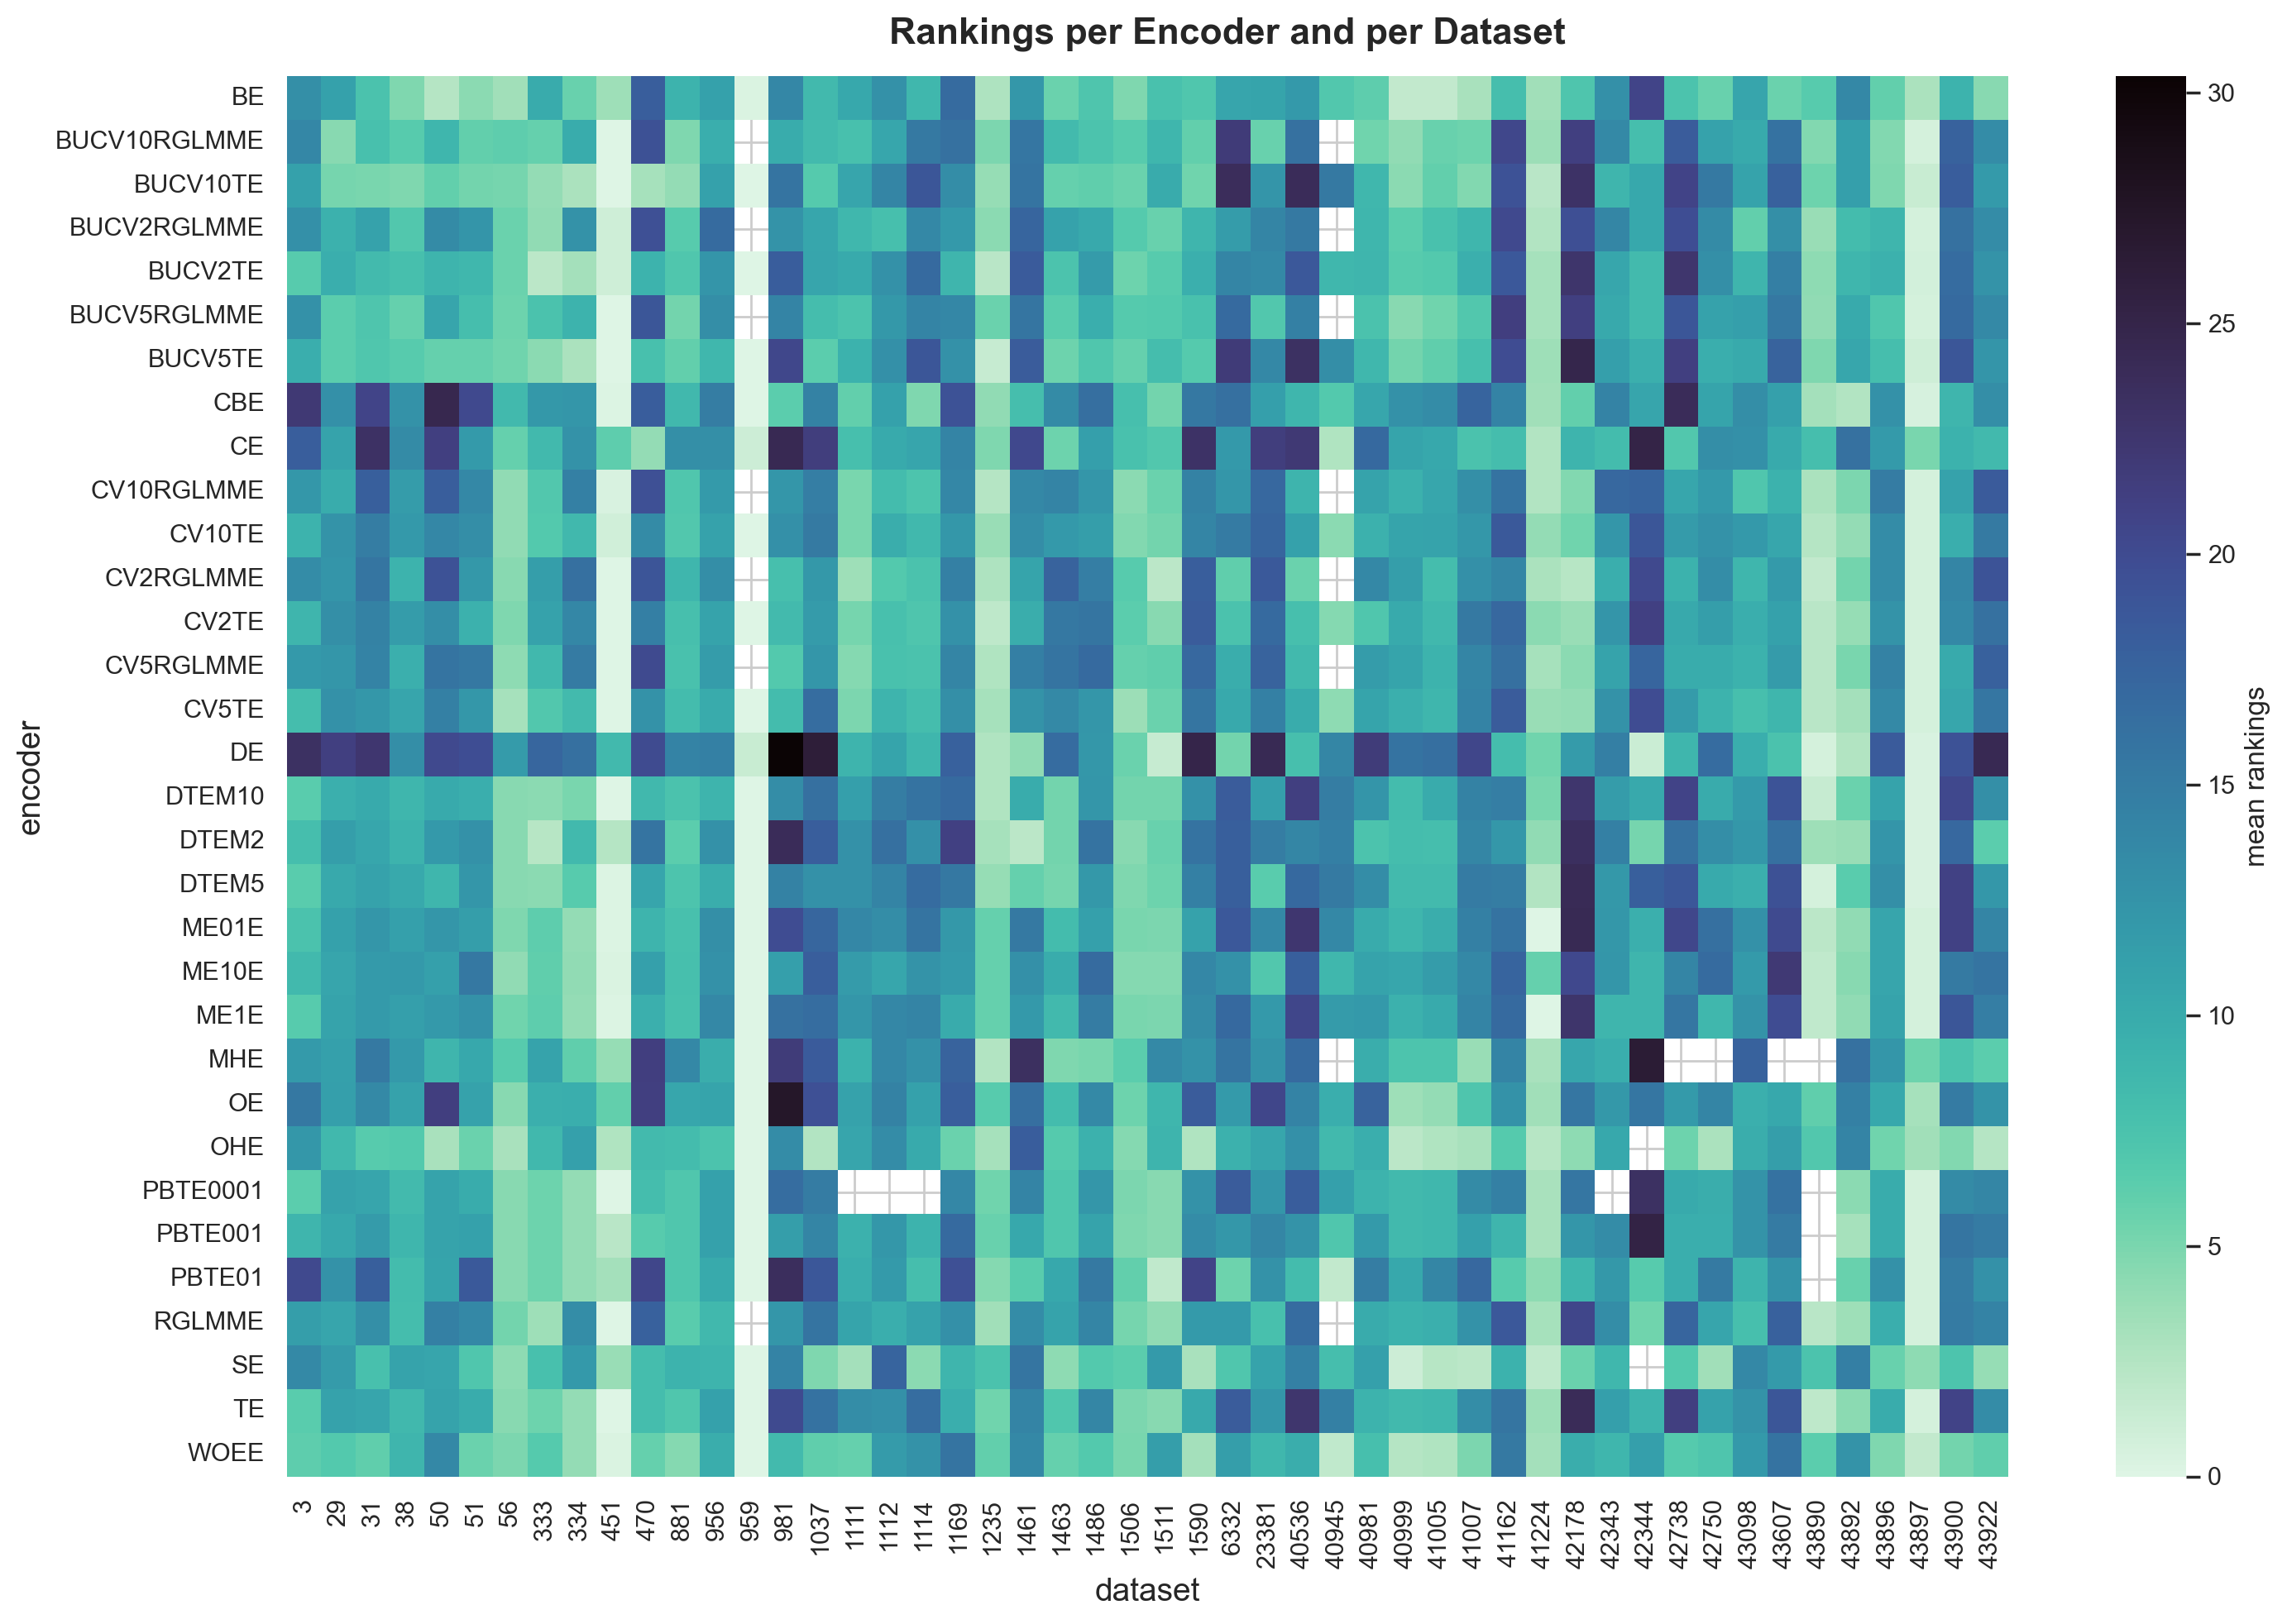

In [608]:
# plot mean of all rankings of each encoder and each dataset in an heatmap
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(encoder_dataset_rankings, ax=ax, cmap="mako_r", cbar_kws={'label': 'mean rankings'})
ax.set_xlabel("dataset", fontsize=14)
ax.set_ylabel("encoder", fontsize=14)
fig.suptitle("Rankings per Encoder and per Dataset", fontweight="bold", fontsize=16)
plt.tight_layout()
plt.show()

### Model

In [609]:
# get mean of all rankings of each encoder and each model
encoder_model_rankings = rankings.groupby(level=1, axis='columns').mean()
encoder_model_rankings

,DTC,KNC,LGBMC,LR,SVC
encoder,,,,,
BE,7.560724,9.943089,7.833333,6.774359,6.920000
BUCV10RGLMME,9.080645,9.658192,9.725352,10.132275,8.266355
BUCV10TE,8.734908,10.330579,8.980000,9.884615,7.346847
BUCV2RGLMME,10.040000,11.336022,9.569444,10.544974,9.109589
BUCV2TE,9.243590,10.726562,9.426667,9.953846,7.755556
BUCV5RGLMME,9.680108,10.033898,10.132867,9.764550,8.369863
BUCV5TE,10.069767,10.555556,8.933333,9.735897,7.444444
CBE,11.496124,12.531250,10.233333,12.500000,9.245614
CE,8.248718,15.139108,7.326667,14.025641,13.862222


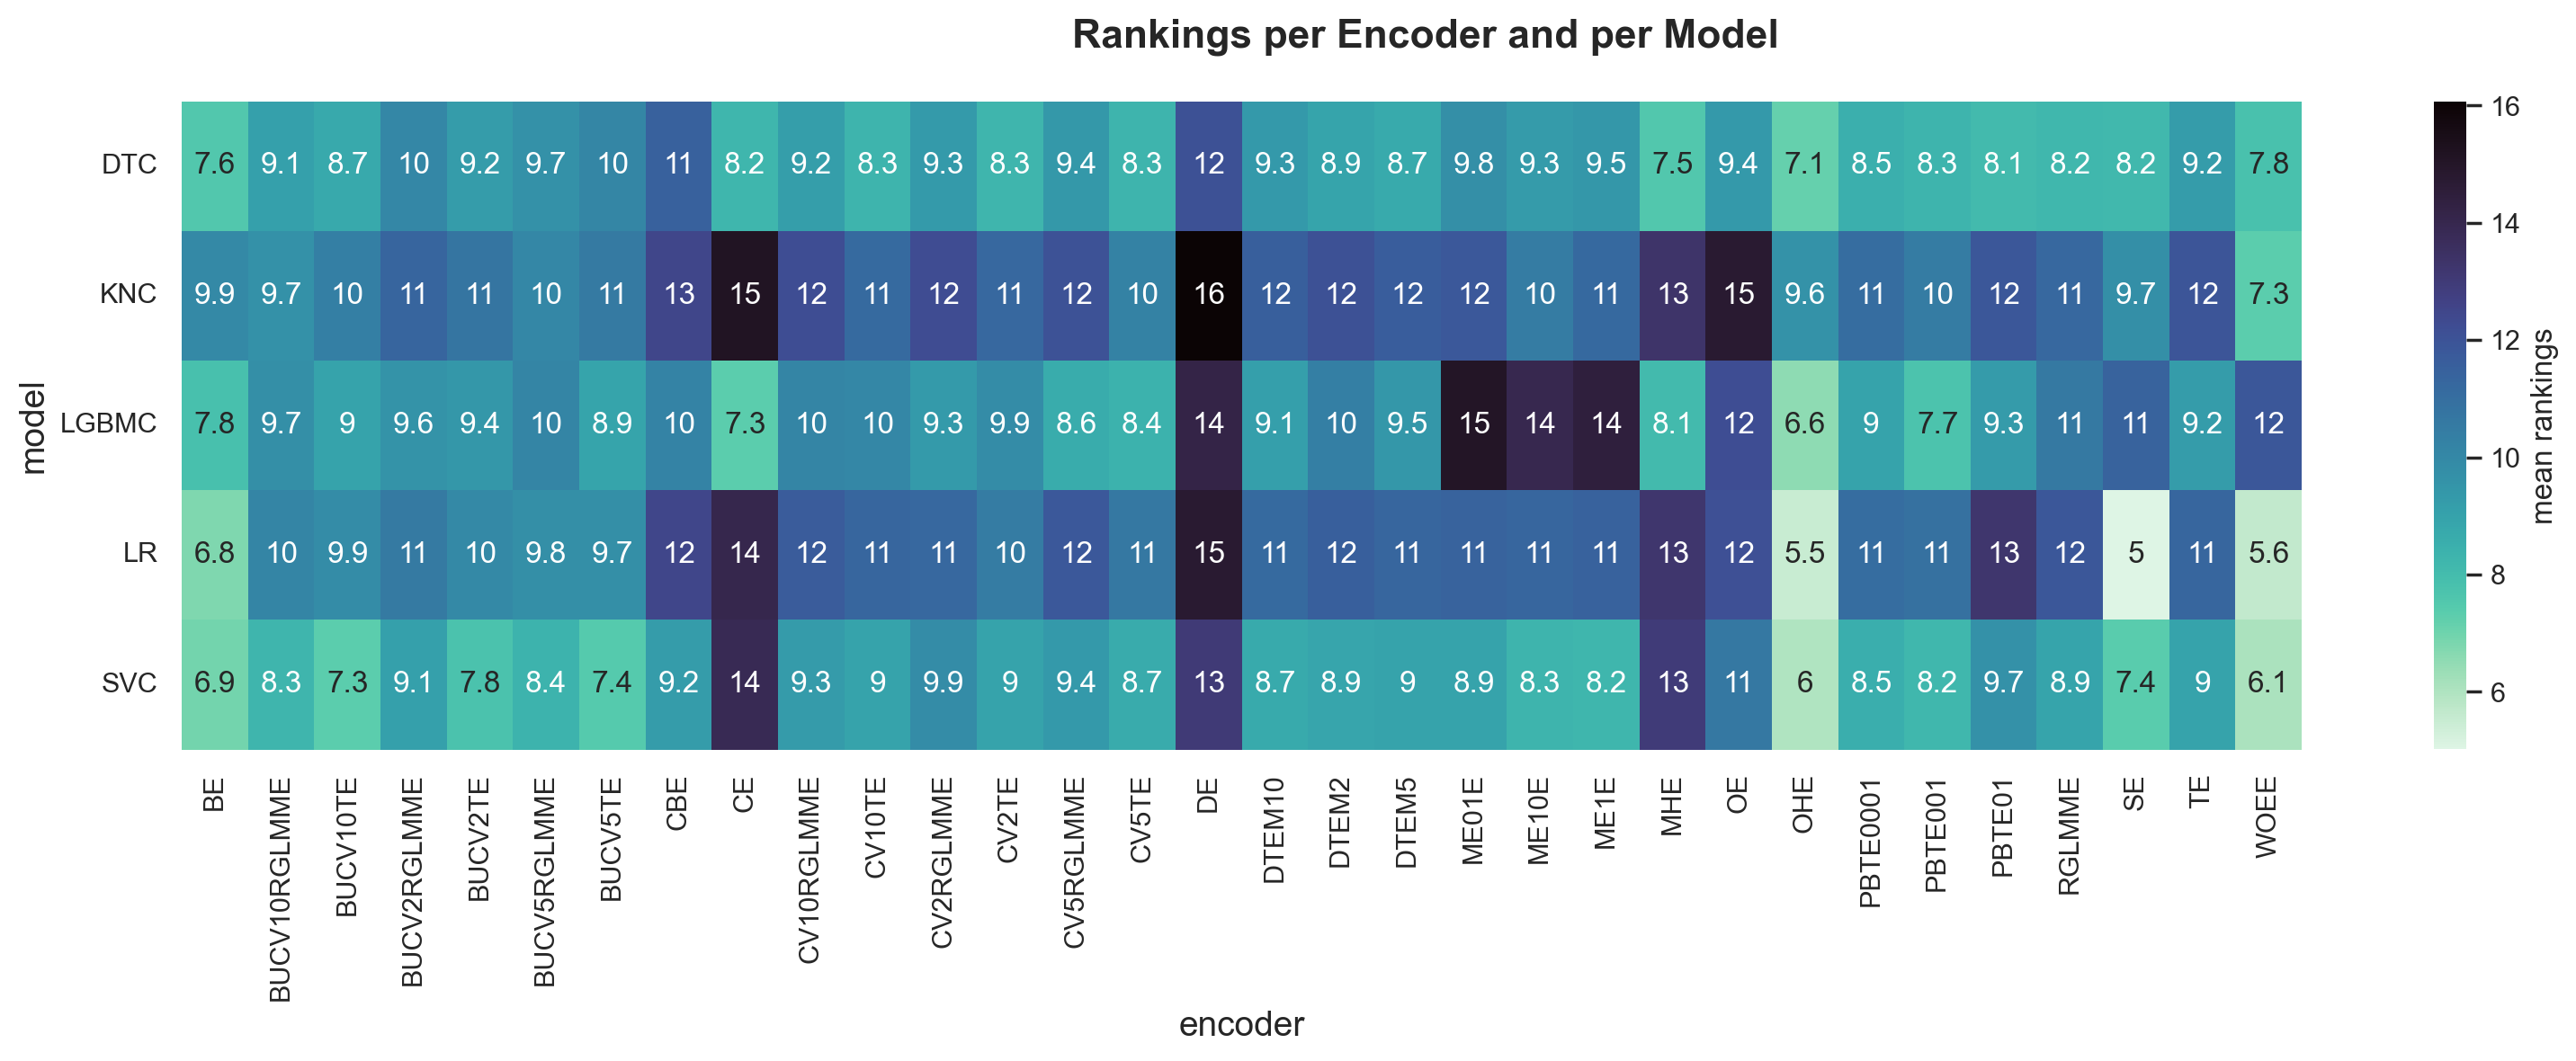

In [636]:
# plot mean of all rankings of each encoder and each model in an heatmap
fig, ax = plt.subplots(figsize=(16, 6))
sns.heatmap(encoder_model_rankings.transpose(), ax=ax, cmap="mako_r", annot=True, cbar_kws={'label': 'mean rankings'})
ax.set_xlabel("encoder", fontsize=14)
ax.set_ylabel("model", fontsize=14)
# rotate yticks
plt.yticks(rotation=0)
fig.suptitle("Rankings per Encoder and per Model", fontweight="bold", fontsize=16)
plt.tight_layout()
plt.show()

## Scoring

In [615]:
# get mean of all rankings of each encoder and each scoring
encoder_scoring_rankings = rankings.groupby(level=3, axis='columns').mean()
encoder_scoring_rankings

,ACC,AUC,F1
encoder,,,
BE,6.731755,8.453649,8.422091
BUCV10RGLMME,8.624230,9.652263,10.032854
BUCV10TE,8.503984,9.352590,9.854582
BUCV2RGLMME,9.211694,10.760081,10.957661
BUCV2TE,8.711501,9.703704,10.366472
BUCV5RGLMME,8.787321,9.916155,10.204918
BUCV5TE,8.731755,9.867850,10.205128
CBE,10.615984,12.253411,11.787524
CE,10.259766,13.054688,13.156250


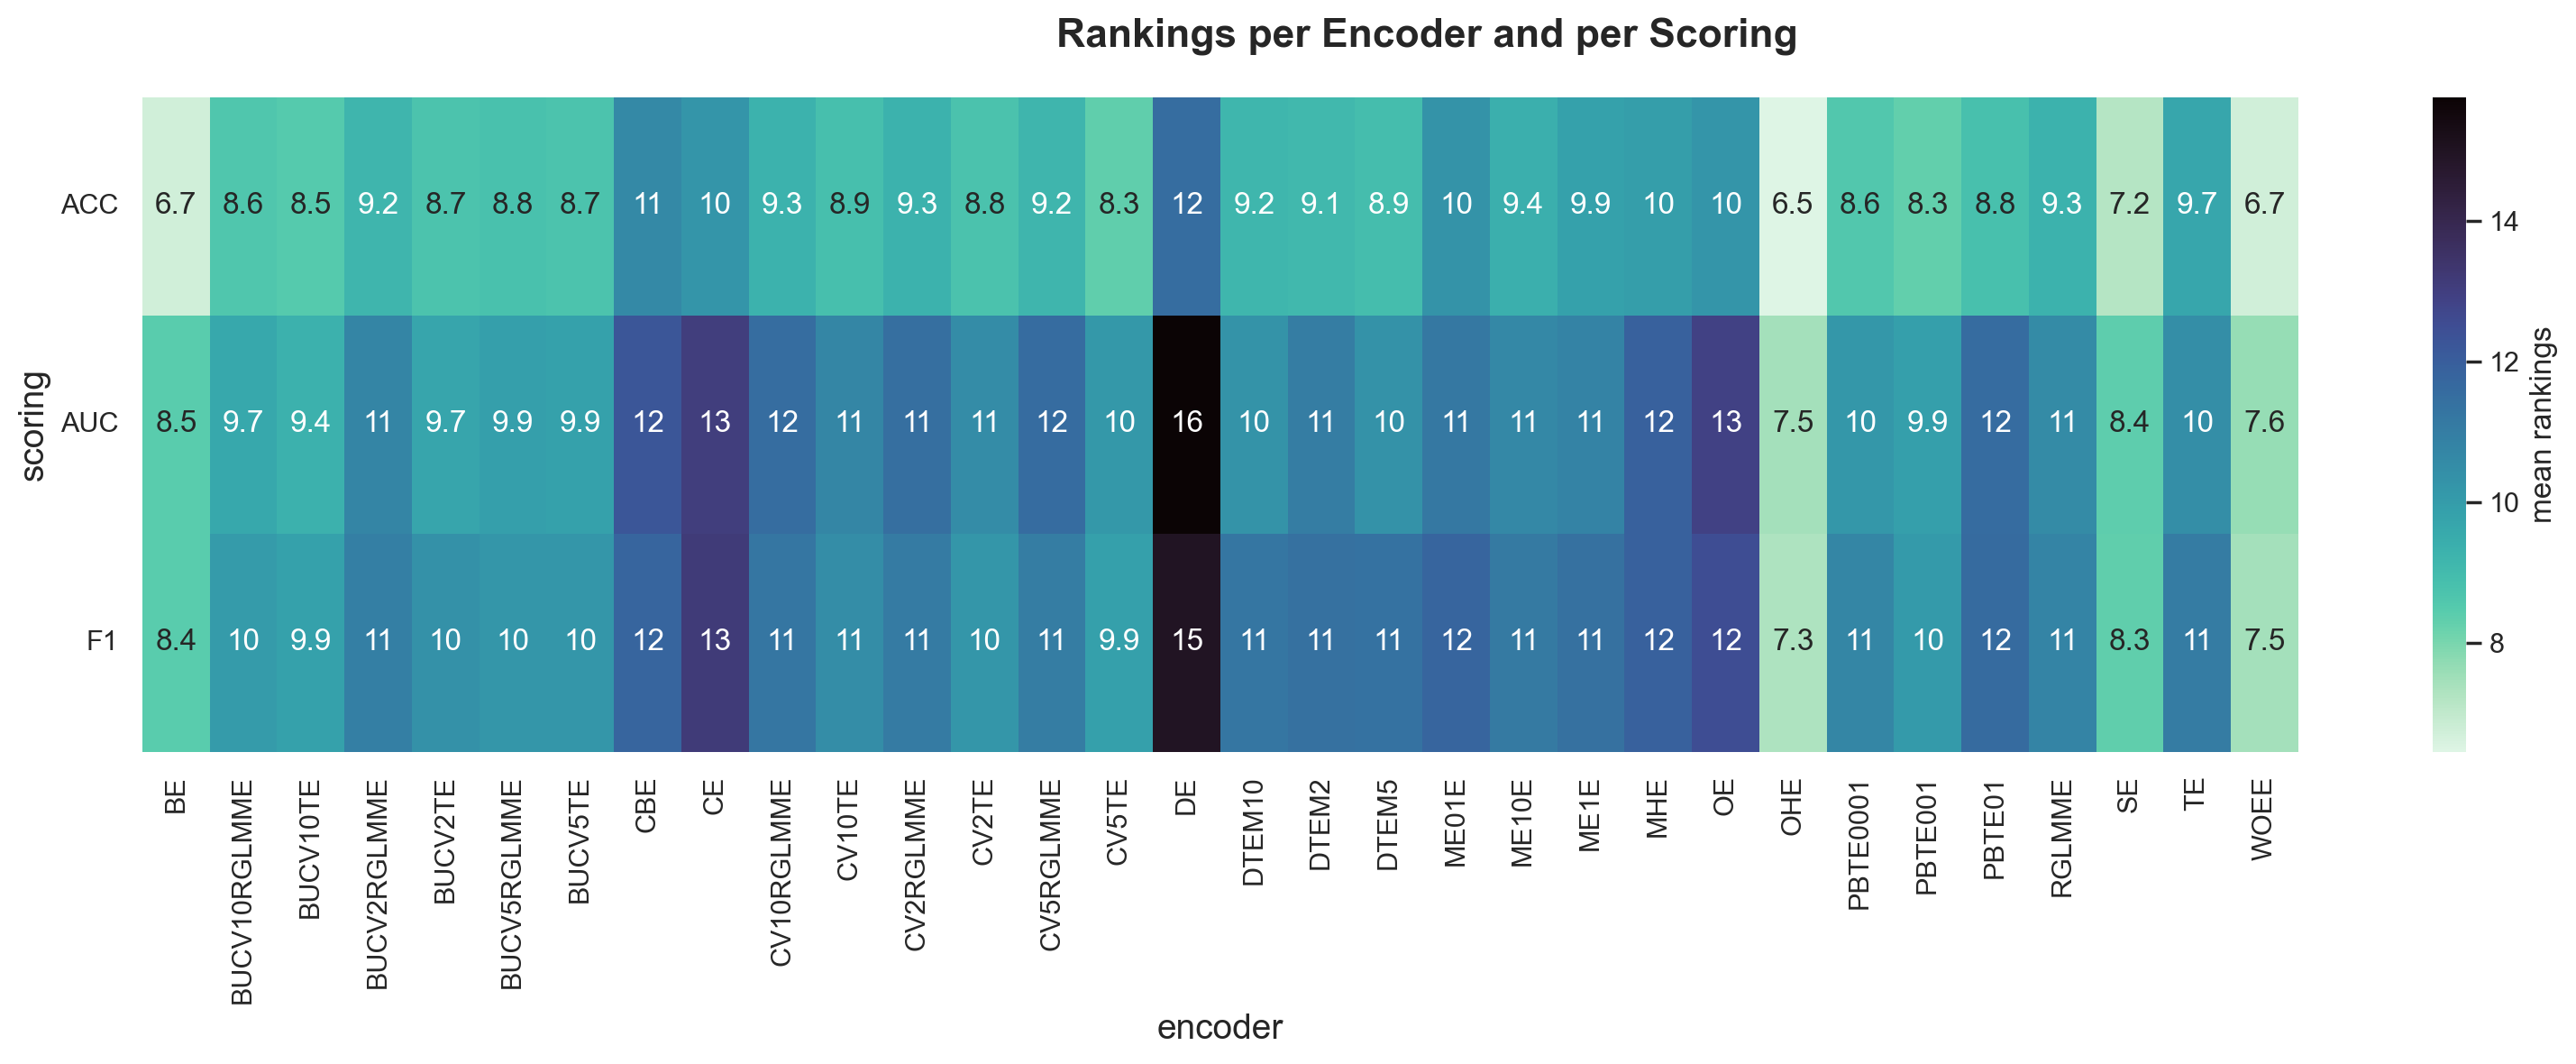

In [641]:
# plot mean of all rankings of each encoder and each scoring in an heatmap
fig, ax = plt.subplots(figsize=(16, 6))
sns.heatmap(encoder_scoring_rankings.transpose(), ax=ax, cmap="mako_r", annot=True, cbar_kws={'label': 'mean rankings'})
ax.set_ylabel("scoring", fontsize=14)
ax.set_xlabel("encoder", fontsize=14)
# rotate yticks
plt.yticks(rotation=0)
fig.suptitle("Rankings per Encoder and per Scoring", fontweight="bold", fontsize=16)
plt.tight_layout()
plt.show()